<a href="https://colab.research.google.com/github/quangtaocaiboong/GitBookTrain/blob/main/La_Quang_Huy_MLP_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [1]:
!pip install d2l==1.0.3


# Implementation of Multilayer Perceptrons
:label:`sec_mlp-implementation`

Multilayer perceptrons (MLPs) are not much more complex to implement than simple linear models. The key conceptual
difference is that we now concatenate multiple layers.


In [2]:
import torch
from torch import nn
from d2l import torch as d2l
import matplotlib.pyplot as plt

## Implementation from Scratch

Let's begin again by implementing such a network from scratch.

### Initializing Model Parameters

Recall that Fashion-MNIST contains 10 classes,
and that each image consists of a $28 \times 28 = 784$
grid of grayscale pixel values.
As before we will disregard the spatial structure
among the pixels for now,
so we can think of this as a classification dataset
with 784 input features and 10 classes.
To begin, we will [**implement an MLP
with one hidden layer and 256 hidden units.**]
Both the number of layers and their width are adjustable
(they are considered hyperparameters).
Typically, we choose the layer widths to be divisible by larger powers of 2.
This is computationally efficient due to the way
memory is allocated and addressed in hardware.

Again, we will represent our parameters with several tensors.
Note that *for every layer*, we must keep track of
one weight matrix and one bias vector.
As always, we allocate memory
for the gradients of the loss with respect to these parameters.


In the code below we use `nn.Parameter`
to automatically register
a class attribute as a parameter to be tracked by `autograd` (:numref:`sec_autograd`).


In [3]:
class MLPScratch(d2l.Classifier):
    def __init__(self, num_inputs, num_outputs, num_hiddens, lr, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.W1 = nn.Parameter(torch.randn(num_inputs, num_hiddens) * sigma)
        self.b1 = nn.Parameter(torch.zeros(num_hiddens))
        self.W2 = nn.Parameter(torch.randn(num_hiddens, num_outputs) * sigma)
        self.b2 = nn.Parameter(torch.zeros(num_outputs))

### Model

To make sure we know how everything works,
we will [**implement the ReLU activation**] ourselves
rather than invoking the built-in `relu` function directly.


In [4]:
def relu(X):
    a = torch.zeros_like(X)
    return torch.max(X, a)

Since we are disregarding spatial structure,
we `reshape` each two-dimensional image into
a flat vector of length  `num_inputs`.
Finally, we (**implement our model**)
with just a few lines of code. Since we use the framework built-in autograd this is all that it takes.


In [5]:
@d2l.add_to_class(MLPScratch)
def forward(self, X):
    X = X.reshape((-1, self.num_inputs))
    H = relu(torch.matmul(X, self.W1) + self.b1)
    return torch.matmul(H, self.W2) + self.b2

### Training

Fortunately, [**the training loop for MLPs
is exactly the same as for softmax regression.**] We define the model, data, and trainer, then finally invoke the `fit` method on model and data.


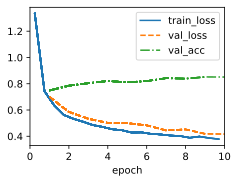

In [6]:
model = MLPScratch(num_inputs=784, num_outputs=10, num_hiddens=256, lr=0.1)
data = d2l.FashionMNIST(batch_size=256)
trainer = d2l.Trainer(max_epochs=10)
trainer.fit(model, data)

## Concise Implementation

As you might expect, by relying on the high-level APIs, we can implement MLPs even more concisely.

### Model

Compared with our concise implementation
of softmax regression implementation
(:numref:`sec_softmax_concise`),
the only difference is that we add
*two* fully connected layers where we previously added only *one*.
The first is [**the hidden layer**],
the second is the output layer.


In [7]:
class MLP(d2l.Classifier):
    def __init__(self, num_outputs, num_hiddens, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.Sequential(nn.Flatten(), nn.LazyLinear(num_hiddens),
                                 nn.ReLU(), nn.LazyLinear(num_outputs))

Previously, we defined `forward` methods for models to transform input using the model parameters.
These operations are essentially a pipeline:
you take an input and
apply a transformation (e.g.,
matrix multiplication with weights followed by bias addition),
then repetitively use the output of the current transformation as
input to the next transformation.
However, you may have noticed that
no `forward` method is defined here.
In fact, `MLP` inherits the `forward` method from the `Module` class (:numref:`subsec_oo-design-models`) to
simply invoke `self.net(X)` (`X` is input),
which is now defined as a sequence of transformations
via the `Sequential` class.
The `Sequential` class abstracts the forward process
enabling us to focus on the transformations.
We will further discuss how the `Sequential` class works in :numref:`subsec_model-construction-sequential`.


### Training

[**The training loop**] is exactly the same
as when we implemented softmax regression.
This modularity enables us to separate
matters concerning the model architecture
from orthogonal considerations.


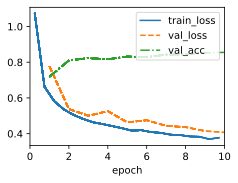

In [8]:
model = MLP(num_outputs=10, num_hiddens=256, lr=0.1)
trainer.fit(model, data)

## Summary

Now that we have more practice in designing deep networks, the step from a single to multiple layers of deep networks does not pose such a significant challenge any longer. In particular, we can reuse the training algorithm and data loader. Note, though, that implementing MLPs from scratch is nonetheless messy: naming and keeping track of the model parameters makes it difficult to extend models. For instance, imagine wanting to insert another layer between layers 42 and 43. This might now be layer 42b, unless we are willing to perform sequential renaming. Moreover, if we implement the network from scratch, it is much more difficult for the framework to perform meaningful performance optimizations.

Nonetheless, you have now reached the state of the art of the late 1980s when fully connected deep networks were the method of choice for neural network modeling. Our next conceptual step will be to consider images. Before we do so, we need to review a number of statistical basics and details on how to compute models efficiently.


## Exercises

1. Change the number of hidden units `num_hiddens` and plot how its number affects the accuracy of the model. What is the best value of this hyperparameter?
1. Try adding a hidden layer to see how it affects the results.
1. Why is it a bad idea to insert a hidden layer with a single neuron? What could go wrong?
1. How does changing the learning rate alter your results? With all other parameters fixed, which learning rate gives you the best results? How does this relate to the number of epochs?
1. Let's optimize over all hyperparameters jointly, i.e., learning rate, number of epochs, number of hidden layers, and number of hidden units per layer.
    1. What is the best result you can get by optimizing over all of them?
    1. Why it is much more challenging to deal with multiple hyperparameters?
    1. Describe an efficient strategy for optimizing over multiple parameters jointly.
1. Compare the speed of the framework and the from-scratch implementation for a challenging problem. How does it change with the complexity of the network?
1. Measure the speed of tensor--matrix multiplications for well-aligned and misaligned matrices. For instance, test for matrices with dimension 1024, 1025, 1026, 1028, and 1032.
    1. How does this change between GPUs and CPUs?
    1. Determine the memory bus width of your CPU and GPU.
1. Try out different activation functions. Which one works best?
1. Is there a difference between weight initializations of the network? Does it matter?


## Exercises

### 5.Let‚Äôs optimize over all hyperparameters jointly, i.e., learning rate, number of epochs, number of hidden layers, and number of hidden units per layer.

In [7]:
# b·ªï sung import
import time
import random
print(f"‚úÖ CUDA available: {torch.cuda.is_available()}")

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"ƒêang s·ª≠ d·ª•ng: {device.upper()}")

‚úÖ CUDA available: True
üì¶ ƒêang s·ª≠ d·ª•ng: CUDA


In [11]:
from torchvision import transforms
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader

# ‚úÖ Vi·∫øt l·∫°i h√†m c√≥ num_workers
def load_data_fashion_mnist(batch_size, resize=None, num_workers=2):
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)

    mnist_train = FashionMNIST(root="./data", train=True, download=True, transform=trans)
    mnist_test = FashionMNIST(root="./data", train=False, download=True, transform=trans)

    return (
        DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=num_workers),
        DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    )


Build MLP Function

In [37]:
def build_mlp(units_per_layer):
    layers = [nn.Flatten()]
    input_dim = 784  # 28x28 ·∫£nh

    for units in units_per_layer:
        layers.append(nn.Linear(input_dim, units))
        layers.append(nn.ReLU())
        input_dim = units

    layers.append(nn.Linear(input_dim, 10))  # output l·ªõp
    return nn.Sequential(*layers).to(device)

In [43]:
def train_mlp(hidden_units, lr, batch_size, num_epochs):
    net = build_mlp(hidden_units)
    net.apply(lambda m: nn.init.xavier_uniform_(m.weight) if isinstance(m, nn.Linear) else None)

    loss = nn.CrossEntropyLoss()
    trainer = torch.optim.SGD(net.parameters(), lr=lr)

    # ‚úÖ tƒÉng t·ªëc load d·ªØ li·ªáu
    train_iter, test_iter = load_data_fashion_mnist(batch_size, num_workers=2)

    for epoch in range(num_epochs):
        net.train()
        for X, y in train_iter:
            X, y = X.to(device), y.to(device)
            trainer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            trainer.step()

    acc = d2l.evaluate_accuracy_gpu(net, test_iter)
    return acc


In [14]:
# Th√¥ng s·ªë c·∫ßn th·ª≠
hidden_options = [64, 128, 256, 512]
lr_options = [0.01, 0.05, 0.1]
batch_options = [32, 64, 128]
num_trials = 5
num_epochs = 10

results = []
start_time = time.time()

for i in range(num_trials):
    hidden_units = [random.choice(hidden_options)]
    # th·ª≠ random th√™m t·∫ßng th·ª© 2
    if random.random() < 0.5:
        hidden_units.append(random.choice(hidden_options))

    lr = random.choice(lr_options)
    batch_size = random.choice(batch_options)

    print(f"\nüé≤ Trial {i+1}/{num_trials} ‚Üí Hidden: {hidden_units}, LR: {lr}, Batch: {batch_size}")
    t0 = time.time()
    acc = train_mlp(hidden_units, lr, batch_size, num_epochs)
    t1 = time.time()

    print(f"‚úÖ Accuracy: {acc:.4f} | ‚è± Th·ªùi gian: {t1 - t0:.2f} gi√¢y")
    results.append((acc, hidden_units, lr, batch_size, t1 - t0))

total_time = time.time() - start_time
print(f"\n‚è± T·ªïng th·ªùi gian t·∫•t c·∫£ trials: {total_time:.2f} gi√¢y")



üé≤ Trial 1/5 ‚Üí Hidden: [512], LR: 0.1, Batch: 32


100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 26.4M/26.4M [00:01<00:00, 13.8MB/s]
100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 29.5k/29.5k [00:00<00:00, 201kB/s]
100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4.42M/4.42M [00:01<00:00, 3.76MB/s]
100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 5.15k/5.15k [00:00<00:00, 10.3MB/s]


‚úÖ Accuracy: 0.8802 | ‚è± Th·ªùi gian: 103.36 gi√¢y

üé≤ Trial 2/5 ‚Üí Hidden: [256, 128], LR: 0.01, Batch: 64
‚úÖ Accuracy: 0.8496 | ‚è± Th·ªùi gian: 76.35 gi√¢y

üé≤ Trial 3/5 ‚Üí Hidden: [512], LR: 0.1, Batch: 64
‚úÖ Accuracy: 0.8726 | ‚è± Th·ªùi gian: 75.50 gi√¢y

üé≤ Trial 4/5 ‚Üí Hidden: [64, 128], LR: 0.1, Batch: 128
‚úÖ Accuracy: 0.8406 | ‚è± Th·ªùi gian: 65.59 gi√¢y

üé≤ Trial 5/5 ‚Üí Hidden: [128, 256], LR: 0.05, Batch: 64
‚úÖ Accuracy: 0.8703 | ‚è± Th·ªùi gian: 85.98 gi√¢y

‚è± T·ªïng th·ªùi gian t·∫•t c·∫£ trials: 406.79 gi√¢y


1. What is the best result you can get by optimizing over all of them?

In [16]:
best = max(results, key=lambda x: x[0])
print(f"\n K·∫øt qu·∫£ t·ªët nh·∫•t: Accuracy = {best[0]:.4f}, Hidden = {best[1]}, LR = {best[2]}, Batch = {best[3]}")


 K·∫øt qu·∫£ t·ªët nh·∫•t: Accuracy = 0.8802, Hidden = [512], LR = 0.1, Batch = 32


Note: do h·∫°n ch·∫ø v·ªÅ ph·∫ßn c·ª©ng n√™n ch·ªâ cho epoch = 10 v√† trial 5 l·∫ßn

2. Why it is much more challenging to deal with multiple hyperparameters?

V√¨ kh√¥ng gian t√¨m ki·∫øm tƒÉng theo c·∫•p s·ªë m≈© khi c√≥ nhi·ªÅu si√™u tham s·ªë, c√°c tham s·ªë th∆∞·ªùng c√≥ m·ªëi quan h·ªá ph·ª©c t·∫°p v·ªõi nhau, v√† m·ªói t·ªï h·ª£p c·∫ßn hu·∫•n luy·ªán m√¥ h√¨nh ƒë·∫ßy ƒë·ªß, r·∫•t t·ªën th·ªùi gian v√† t√†i nguy√™n.


3. Describe an efficient strategy for optimizing over multiple parameters jointly.

S·ª≠ d·ª•ng Bayesian Optimization (v√≠ d·ª• v·ªõi Optuna ho·∫∑c Hyperopt), v√¨ n√≥ d·ª± ƒëo√°n t·ªï h·ª£p si√™u tham s·ªë t·ªët ti·∫øp theo d·ª±a tr√™n k·∫øt qu·∫£ c√°c th·ª≠ nghi·ªám tr∆∞·ªõc, gi√∫p gi·∫£m s·ªë l·∫ßn hu·∫•n luy·ªán c·∫ßn thi·∫øt.

In [18]:
!pip install -q optuna torchvision

In [21]:
import optuna

Set M·ª•c ti√™u cho Optuna

In [44]:
def objective(trial):
    # C√°c si√™u tham s·ªë s·∫Ω ƒë∆∞·ª£c t·ªëi ∆∞u
    lr = trial.suggest_float("lr", 1e-3, 0.2, log=True)
    num_epochs = trial.suggest_int("epochs", 5, 20)
    num_layers = trial.suggest_int("num_layers", 1, 3)
    units_per_layer = [
        trial.suggest_int(f"units_l{i}", 64, 512, step=64)
        for i in range(num_layers)
    ]
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])

    net = build_mlp(units_per_layer)
    net.apply(lambda m: nn.init.xavier_uniform_(m.weight) if isinstance(m, nn.Linear) else None)

    loss = nn.CrossEntropyLoss()
    trainer = torch.optim.SGD(net.parameters(), lr=lr)
    train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

    for epoch in range(num_epochs):
        net.train()
        for X, y in train_iter:
            X, y = X.to(device), y.to(device)
            trainer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            trainer.step()

    acc = d2l.evaluate_accuracy_gpu(net, test_iter)
    return acc

D√πng Optuna t·ªëi ∆∞u

In [45]:
study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=20)
study.optimize(objective, n_trials=10)
# th·ª≠ 10 l·∫ßn, 20 t·ªën th·ªùi gian h∆°n 30p

print("\n K·∫øt qu·∫£ t·ªët nh·∫•t:")
print(study.best_trial)

[I 2025-05-08 12:57:16,247] A new study created in memory with name: no-name-08b51c62-dc77-4ad0-b71d-9196c3828928
[I 2025-05-08 12:58:07,306] Trial 0 finished with value: 0.8433 and parameters: {'lr': 0.02805167909216037, 'epochs': 7, 'num_layers': 1, 'units_l0': 256, 'batch_size': 128}. Best is trial 0 with value: 0.8433.
[I 2025-05-08 13:01:37,838] Trial 1 finished with value: 0.8628 and parameters: {'lr': 0.0033566194538708527, 'epochs': 20, 'num_layers': 3, 'units_l0': 192, 'units_l1': 320, 'units_l2': 64, 'batch_size': 32}. Best is trial 1 with value: 0.8628.
[I 2025-05-08 13:03:26,634] Trial 2 finished with value: 0.8351 and parameters: {'lr': 0.0037682411772077097, 'epochs': 14, 'num_layers': 1, 'units_l0': 384, 'batch_size': 64}. Best is trial 1 with value: 0.8628.
[I 2025-05-08 13:04:05,917] Trial 3 finished with value: 0.8668 and parameters: {'lr': 0.09625660930944435, 'epochs': 5, 'num_layers': 1, 'units_l0': 256, 'batch_size': 64}. Best is trial 3 with value: 0.8668.
[I 202

KeyboardInterrupt: 

### 6. Compare the speed of the framework and the from-scratch implementation for a challenging problem. How does it change with the complexity of the network?

**So s√°nh t·ªëc ƒë·ªô: PyTorch (framework) vs. T·ª± c√†i (from-scratch)**

Trong ph·∫ßn n√†y, ch√∫ng ta s·∫Ω hu·∫•n luy·ªán m·ªôt m·∫°ng n∆°-ron nhi·ªÅu t·∫ßng tr√™n t·∫≠p d·ªØ li·ªáu ƒë∆°n gi·∫£n  
v·ªõi 2 c√°ch:
- D√πng PyTorch (framework chuy√™n d·ª•ng, t·∫≠n d·ª•ng GPU)
- D√πng NumPy (t·ª± c√†i t·ª´ ƒë·∫ßu, kh√¥ng t·ªëi ∆∞u)

Ta s·∫Ω ƒëo th·ªùi gian hu·∫•n luy·ªán ƒë·ªÉ th·∫•y s·ª± kh√°c bi·ªát khi m·∫°ng tr·ªü n√™n ph·ª©c t·∫°p h∆°n.


In [49]:
from torchvision import datasets, transforms
import numpy as np
class TorchMLP(nn.Module):
    def __init__(self, input_size=784, hidden_sizes=[256, 128], output_size=10):
        super().__init__()
        layers = [nn.Flatten()]
        in_dim = input_size
        for h in hidden_sizes:
            layers.append(nn.Linear(in_dim, h))
            layers.append(nn.ReLU())
            in_dim = h
        layers.append(nn.Linear(in_dim, output_size))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Load data (just 1 batch for fair comparison)
transform = transforms.ToTensor()
train_dataset = datasets.FashionMNIST(root="./data", train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)

X_batch, y_batch = next(iter(train_loader))
X_np = X_batch.view(X_batch.shape[0], -1).numpy()
y_np = y_batch.numpy()

# ----- Benchmark PyTorch -----
torch_model = TorchMLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(torch_model.parameters(), lr=0.1)

start_torch = time.time()
for _ in range(10):  # 10 epochs
    optimizer.zero_grad()
    output = torch_model(X_batch.to(device))
    loss = criterion(output, y_batch.to(device))
    loss.backward()
    optimizer.step()
end_torch = time.time()

print(f"‚ö° PyTorch training time: {end_torch - start_torch:.4f} seconds")

# ----- From-scratch version (NumPy) -----
def relu(x):
    return np.maximum(0, x)

def softmax(x):
    e = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e / np.sum(e, axis=1, keepdims=True)

def cross_entropy(y_pred, y_true):
    m = y_pred.shape[0]
    p = y_pred[range(m), y_true]
    log_likelihood = -np.log(p + 1e-8)
    return np.sum(log_likelihood) / m

# Init weights
np.random.seed(42)
W1 = np.random.randn(784, 256) * 0.01
b1 = np.zeros((1, 256))
W2 = np.random.randn(256, 128) * 0.01
b2 = np.zeros((1, 128))
W3 = np.random.randn(128, 10) * 0.01
b3 = np.zeros((1, 10))

lr = 0.1
start_numpy = time.time()
for epoch in range(10):
    # Forward
    z1 = X_np @ W1 + b1
    a1 = relu(z1)
    z2 = a1 @ W2 + b2
    a2 = relu(z2)
    z3 = a2 @ W3 + b3
    probs = softmax(z3)

    # Loss
    loss = cross_entropy(probs, y_np)

    # Backward (manual gradient descent)
    m = y_np.shape[0]
    grad_z3 = probs
    grad_z3[range(m), y_np] -= 1
    grad_z3 /= m

    dW3 = a2.T @ grad_z3
    db3 = np.sum(grad_z3, axis=0, keepdims=True)

    da2 = grad_z3 @ W3.T
    dz2 = da2 * (z2 > 0)

    dW2 = a1.T @ dz2
    db2 = np.sum(dz2, axis=0, keepdims=True)

    da1 = dz2 @ W2.T
    dz1 = da1 * (z1 > 0)

    dW1 = X_np.T @ dz1
    db1 = np.sum(dz1, axis=0, keepdims=True)

    # Update
    W1 -= lr * dW1
    b1 -= lr * db1
    W2 -= lr * dW2
    b2 -= lr * db2
    W3 -= lr * dW3
    b3 -= lr * db3
end_numpy = time.time()

print(f"From-scratch (NumPy) training time: {end_numpy - start_numpy:.4f} seconds")

‚ö° PyTorch training time: 0.0216 seconds
From-scratch (NumPy) training time: 0.3217 seconds


C√†ng tƒÉng s·ªë t·∫ßng ·∫©n ho·∫∑c batch size ‚Üí kho·∫£ng c√°ch c√†ng l·ªõn gi·ªØa hai c√°ch ti·∫øp c·∫≠n.

## 7. Measure the speed of tensor‚Äìmatrix multiplications for well-aligned and misaligned matrices. For instance, test for matrices with dimension 1024, 1025, 1026, 1028, and 1032.

1.  How does this change between GPUs and CPUs?
2.  Determine the memory bus width of your CPU and GPU.





**H√†m ƒëo th·ªùi gian nh√¢n ma tr·∫≠n**

In [50]:
def benchmark_matmul(size, device, num_trials=10):
    A = torch.randn(size, size, device=device)
    B = torch.randn(size, size, device=device)

    # warm-up
    _ = torch.matmul(A, B)

    torch.cuda.synchronize() if device.type == 'cuda' else None
    start = time.time()

    for _ in range(num_trials):
        C = torch.matmul(A, B)

    torch.cuda.synchronize() if device.type == 'cuda' else None
    end = time.time()

    avg_time = (end - start) / num_trials
    return avg_time


**Ch·∫°y benchmark cho nhi·ªÅu k√≠ch th∆∞·ªõc**

In [52]:
device_cpu = torch.device("cpu")
device_gpu = torch.device("cuda") if torch.cuda.is_available() else None

sizes = [1024, 1025, 1026, 1028, 1032]

print("üîç Benchmark on CPU:")
for sz in sizes:
    t = benchmark_matmul(sz, device_cpu)
    print(f"Size {sz}x{sz}: {t:.6f} sec")

if device_gpu:
    print("\nüöÄ Benchmark on GPU:")
    for sz in sizes:
        t = benchmark_matmul(sz, device_gpu)
        print(f"Size {sz}x{sz}: {t:.6f} sec")


üîç Benchmark on CPU:
Size 1024x1024: 0.018252 sec
Size 1025x1025: 0.016673 sec
Size 1026x1026: 0.017933 sec
Size 1028x1028: 0.017886 sec
Size 1032x1032: 0.015785 sec

üöÄ Benchmark on GPU:
Size 1024x1024: 0.000833 sec
Size 1025x1025: 0.000988 sec
Size 1026x1026: 0.000987 sec
Size 1028x1028: 0.000978 sec
Size 1032x1032: 0.000972 sec


T√¨m k·∫øt qu·∫£ bench mark

In [53]:
!lshw -C display | grep width
!lscpu | grep Width

/bin/bash: line 1: lshw: command not found


### 8. Try out different activation functions. Which one works best?

T·∫°o 1 data set nh·∫π h∆°n

In [54]:
# Dataset
transform = transforms.ToTensor()
train_data = datasets.FashionMNIST(root="./data", train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128)

**ƒê·ªãnh nghƒ©a m·∫°ng MLP v·ªõi activation linh ho·∫°t**

In [55]:
class MLP(nn.Module):
    def __init__(self, activation_fn):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.out = nn.Linear(128, 10)
        self.activation = activation_fn

    def forward(self, x):
        x = self.flatten(x)
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        return self.out(x)


**train + test**

In [60]:
def train_and_evaluate(activation_fn, name):
    model = MLP(activation_fn).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Train
    model.train()
    for epoch in range(5):
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()

    # Evaluate
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            preds = model(X).argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    acc = correct / total
    print(f"üîπ {name}: Accuracy = {acc:.4f}")
    return acc


**Ch·∫°y t·∫•t c·∫£ activation functions**

Bao g·ªìm:


*   ReLU

* Sigmoid

* Tanh

* Leaky ReLU

* ELU




In [58]:
import torch.nn.functional as F
activations = {
    "ReLU": F.relu,
    "Sigmoid": torch.sigmoid,
    "Tanh": torch.tanh,
    "LeakyReLU": F.leaky_relu,
    "ELU": F.elu
}

results = {}
for name, act_fn in activations.items():
    print(f"\nüöÄ Testing activation: {name}")
    acc = train_and_evaluate(act_fn, name)
    results[name] = acc

# T·ªïng k·∫øt
print("\nüìä K·∫øt qu·∫£ t·ªïng h·ª£p:")
for name, acc in results.items():
    print(f"{name}: {acc:.4f}")



üöÄ Testing activation: ReLU
üîπ ReLU: Accuracy = 0.8754

üöÄ Testing activation: Sigmoid
üîπ Sigmoid: Accuracy = 0.8680

üöÄ Testing activation: Tanh
üîπ Tanh: Accuracy = 0.8705

üöÄ Testing activation: LeakyReLU
üîπ LeakyReLU: Accuracy = 0.8716

üöÄ Testing activation: ELU
üîπ ELU: Accuracy = 0.8629

üìä K·∫øt qu·∫£ t·ªïng h·ª£p:
ReLU: 0.8754
Sigmoid: 0.8680
Tanh: 0.8705
LeakyReLU: 0.8716
ELU: 0.8629


### 9. Is there a difference between weight initializations of the network? Does it matter?

| Ph∆∞∆°ng ph√°p         | M√¥ t·∫£ ng·∫Øn                   | D√πng t·ªët v·ªõi         |
| ------------------- | ---------------------------- | -------------------- |
| **Random Normal**   | Tr·ªçng s·ªë t·ª´ ph√¢n ph·ªëi chu·∫©n  | C∆° b·∫£n, d·ªÖ b·ªã m·∫•t ·ªïn |
| **Xavier (Glorot)** | C√¢n b·∫±ng s·ªë chi·ªÅu ƒë·∫ßu v√†o/ra | `tanh`, `sigmoid`    |
| **Kaiming (He)**    | D√†nh cho ReLU v√† bi·∫øn th·ªÉ    | `ReLU`, `LeakyReLU`  |
| **Constant/Zero**   | T·ªá ‚Äî kh√¥ng h·ªçc ƒë∆∞·ª£c g√¨       | ‚ùå Kh√¥ng d√πng         |



In [59]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )
    def forward(self, x): return self.net(x)

# H√†m kh·ªüi t·∫°o
def init_weights(net, method):
    for m in net.modules():
        if isinstance(m, nn.Linear):
            if method == 'xavier':
                nn.init.xavier_uniform_(m.weight)
            elif method == 'he':
                nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
            elif method == 'random':
                nn.init.normal_(m.weight, mean=0, std=1)

# Train & test nhanh
def train_and_eval(init):
    net = MLP()
    init_weights(net, init)
    net.to("cuda")
    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.1)
    for X, y in train_loader:
        X, y = X.cuda(), y.cuda()
        optimizer.zero_grad()
        l = loss(net(X), y)
        l.backward()
        optimizer.step()
        break  # ch·ªâ 1 batch cho nhanh
    # test nhanh
    net.eval()
    X, y = next(iter(test_loader))
    acc = (net(X.cuda()).argmax(1) == y.cuda()).float().mean().item()
    print(f"{init} init ‚Üí acc: {acc:.4f}")

# Th·ª≠ c√°c ph∆∞∆°ng ph√°p
for method in ['random', 'xavier', 'he']:
    train_and_eval(method)

random init ‚Üí acc: 0.1953
xavier init ‚Üí acc: 0.3750
he init ‚Üí acc: 0.2109


C√≥ s·ª± kh√°c bi·ªát r√µ r·ªát gi·ªØa c√°c ph∆∞∆°ng ph√°p kh·ªüi t·∫°o tr·ªçng s·ªë trong m·∫°ng n∆°-ron, v√† ƒëi·ªÅu ƒë√≥ ·∫£nh h∆∞·ªüng r·∫•t l·ªõn ƒë·∫øn hi·ªáu su·∫•t h·ªçc c·ªßa m√¥ h√¨nh. Vi·ªác kh·ªüi t·∫°o tr·ªçng s·ªë l√† b∆∞·ªõc ƒë·∫ßu ti√™n trong qu√° tr√¨nh hu·∫•n luy·ªán m·∫°ng, quy·∫øt ƒë·ªãnh c√°ch d·ªØ li·ªáu v√† gradient lan truy·ªÅn trong m·∫°ng.

N·∫øu kh·ªüi t·∫°o kh√¥ng ph√π h·ª£p, v√≠ d·ª• nh∆∞ t·∫•t c·∫£ tr·ªçng s·ªë b·∫±ng 0 ho·∫∑c l·∫•y ng·∫´u nhi√™n kh√¥ng ki·ªÉm so√°t, m√¥ h√¨nh d·ªÖ g·∫∑p c√°c v·∫•n ƒë·ªÅ nh∆∞ m·∫•t gradient (vanishing gradients) ho·∫∑c gradient b√πng n·ªï (exploding gradients), d·∫´n ƒë·∫øn hu·∫•n luy·ªán ch·∫≠m ho·∫∑c kh√¥ng h·ªôi t·ª•.

Ng∆∞·ª£c l·∫°i, c√°c ph∆∞∆°ng ph√°p kh·ªüi t·∫°o nh∆∞ Xavier (Glorot) ho·∫∑c He (Kaiming) ƒë∆∞·ª£c thi·∫øt k·∫ø d·ª±a tr√™n ƒë·∫∑c t√≠nh to√°n h·ªçc c·ªßa m·∫°ng ƒë·ªÉ gi√∫p t√≠n hi·ªáu lan truy·ªÅn ·ªïn ƒë·ªãnh h∆°n trong qu√° tr√¨nh hu·∫•n luy·ªán. C·ª• th·ªÉ:

Xavier ph√π h·ª£p v·ªõi activation nh∆∞ tanh ho·∫∑c sigmoid

He ph√π h·ª£p v·ªõi ReLU v√† c√°c bi·∫øn th·ªÉ c·ªßa n√≥

V√¨ v·∫≠y, kh·ªüi t·∫°o tr·ªçng s·ªë ƒë√∫ng c√°ch kh√¥ng ch·ªâ gi√∫p m√¥ h√¨nh h·ªçc nhanh h∆°n m√† c√≤n c·∫£i thi·ªán ƒë·ªô ch√≠nh x√°c v√† ƒë·ªô ·ªïn ƒë·ªãnh khi hu·∫•n luy·ªán.

[Discussions](https://discuss.d2l.ai/t/93)
